In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
random.seed(42)
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split


In [2]:
data = make_classification(n_samples=50, 
                           n_features=2, 
                           n_informative=2,
                           n_redundant=0, 
                           n_classes=2,
                           n_clusters_per_class=1, 
                           scale=10.0,
                           random_state=42) # class is split evenly, half 1 and half 0

df = pd.DataFrame(data[0], columns=["a","b"])
labels = pd.DataFrame(data[1], columns=["class"])

df_full = pd.concat([df, labels], axis=1)

num_true = 18 # number of true labels to assign to M (and false to F)
num_false = 7 # number of false labels to assign to M (and true to F)

df_full['male'] = 0 # in this example, 0 means female and 1 means male

df_true = df_full[df_full['class'] == 1]
df_false = df_full[df_full['class'] == 0]

df_true = df_true.reset_index()
df_false = df_false.reset_index()

rand_true = random.sample(range(len(df_true)), num_true)
rand_false = random.sample(range(len(df_false)), num_false)

df_true.loc[rand_true, 'male'] = 1
df_false.loc[rand_false, 'male'] = 1

df_full = pd.concat([df_true, df_false])
df_full = df_full.set_index('index')
df_full = df_full.sample(frac=1) # shuffle

df = df_full[['a', 'b', 'male']]
labels = df_full['class']

X_train, X_test, y_train, y_test = train_test_split(df, labels, random_state=42)

# model = RandomForestClassifier()
model = LogisticRegression()

# Cross val score
print(np.mean(cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')))

# Fit and train on test.
model.fit(X_train, y_train)
print(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

1.0
0.9


In [3]:
pd.concat([df, labels], axis=1)

,a,b,male,class
index,,,,
27,-5.779117,12.846769,1,1
22,11.588354,-10.293834,0,0
17,9.606250,-1.624628,0,0
16,2.511160,-1.432883,0,0
43,11.110598,11.968945,1,1
29,12.691980,8.401020,1,1
34,14.818515,-23.134092,0,0
36,19.176588,7.235894,0,1
14,11.645455,-27.068026,1,0


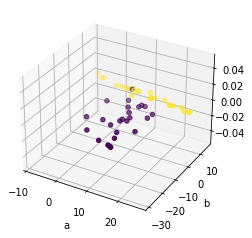

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
a = df.to_numpy()[:,0]
b = df.to_numpy()[:,1]
male = df.to_numpy()[:,2]

ax.scatter(a, b, c=labels.to_numpy())

ax.set_xlabel('a')
ax.set_ylabel('b')

plt.show()

Text(0, 0.5, 'b')

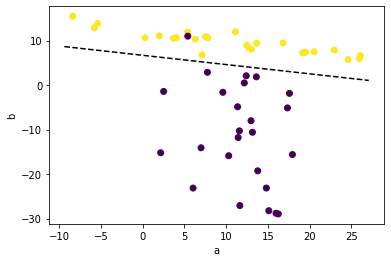

In [5]:
b_coeff = model.intercept_[0]
w1, w2, w3 = model.coef_.T
c = -b_coeff/w2
m = -w1/w2

a_min, a_max = min(a) - 1, max(a) + 1

x = np.array([a_min, a_max])
y = m*x + c

plt.plot(x, y, 'k', ls='--')
plt.scatter(a, b, c=labels.to_numpy())
plt.xlabel('a')
plt.ylabel('b')

Text(0, 0.5, 'b')

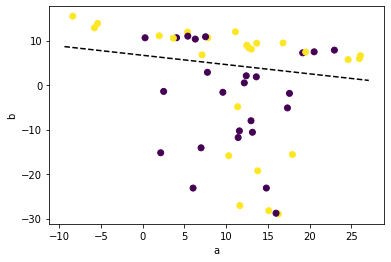

In [6]:
plt.plot(x, y, 'k', ls='--')
plt.scatter(a, b, c=male) # think M = yellow, F = purple?
plt.xlabel('a')
plt.ylabel('b')

In [7]:
from swap_auditor import NaiveSwapAuditor
df['id'] = np.arange(len(df))
new = NaiveSwapAuditor(data=df, predictor=model, id_column="id",protected_classes=['male'], target_col='class')
new.calculate_all_stability(marginal_features=['a','b'])

In [8]:
endpoint_0, endpoint_1 = np.array([a_min, y[0]]), np.array([a_max, y[-1]])

def get_euclidean_distance(a_x, b_x):
    return np.cross(endpoint_1 - endpoint_0, endpoint_0 - np.array([a_x, b_x]))/np.linalg.norm(endpoint_1 - endpoint_0)

df['euclidean_distance'] = df.apply(lambda x: get_euclidean_distance(x.a, x.b), axis=1)
df['stability'] = df.apply(lambda x: new._retrieve_stability_individual(int(x.id))[0], axis=1)
print(df)

               a          b  male  id  euclidean_distance  stability
index                                                               
27     -5.779117  12.846769     1   0           -4.854335   0.520000
22     11.588354 -10.293834     0   1           14.259424   0.520000
17      9.606250  -1.624628     0   2            6.176404   0.520000
16      2.511160  -1.432883     0   3            7.435206   0.546667
43     11.110598  11.968945     1   4           -7.438360   0.546667
29     12.691980   8.401020     1   5           -4.267779   0.546667
34     14.818515 -23.134092     0   6           26.171440   0.520000
36     19.176588   7.235894     0   7           -4.449183   0.773333
14     11.645455 -27.068026     1   8           30.669660   0.786667
48     11.375774  -4.878652     1   9            9.001318   0.786667
24     12.982104  -8.017408     0  10           11.746658   0.520000
10      5.381261  11.895412     1  11           -6.198296   0.546667
19      4.057696  10.629828     0 

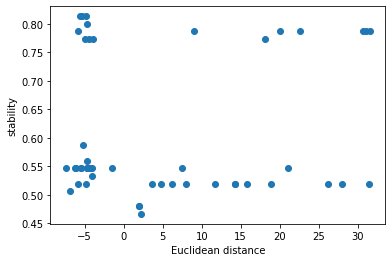

In [9]:
plt.scatter(df['euclidean_distance'], df['stability'])
plt.xlabel('Euclidean distance')
plt.ylabel('stability')
plt.show()

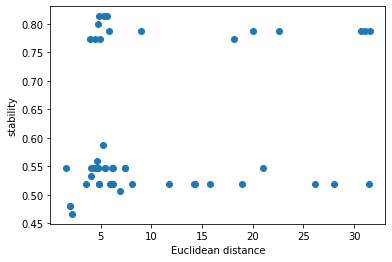

In [10]:
plt.scatter(np.abs(df['euclidean_distance']), df['stability'])
plt.xlabel('Euclidean distance')
plt.ylabel('stability')
plt.show()

In [18]:
m = df[df['male'] == 1]
f = df[df['male'] == 0]

print(f'Average male stability: {m["stability"].mean()}')
print(f'Average female stability: {f["stability"].mean()}')

Average male stability: 0.6112
Average female stability: 0.6042666666666667
